# Задание:
- Установите размер изображения равным 512
- Замените нейросеть на VGG-16
- Поменяйте вес вклада стиля и контента, в общую лосс-функцию (например, на 1000 к 1)
- Сгенерируйте собственное NST изображение для выбранных вами входных, контент- и стилевых изображений

Задание выполнено в GoogleClolab, сохранено и перенесенов в VSCode

In [44]:
# Импортируем библиотеки и модули для работы
# Для работы с нейросетями
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
# Для работы с изображениями
from PIL import Image
import matplotlib.pyplot as plt
# Оптимизация и преобразования изображения
import torchvision.transforms as transforms
import logging
# Переобучение модели
from torchvision.models import vgg16, VGG16_Weights
# Для создания копии объёектов
import copy

In [28]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.set_default_device(device)
device

device(type='cpu')

In [29]:
# Определяем размер изображения
imsize = 512 if torch.cuda.is_available() else 128  # Устанавливаем размер изображения в зависимости от наличия GPU

# Подготовка трансформаций
loader = transforms.Compose([
    transforms.Resize(imsize),        # Масштабируем изображение
    transforms.CenterCrop(imsize),    # Обрезаем края для получения квадратного изображения
    transforms.ToTensor()             # Преобразуем в Tensor
])

# Функция загрузки изображения
def image_loader(image_name):
    try:
        image = Image.open(image_name).convert('RGB')  # Открываем изображение и конвертируем его в RGB
    except Exception as e:
        print(f"Ошибка при загрузке изображения {image_name}: {e}")
        return None

    # Добавляем размерность для батча и отправляем на нужное устройство (GPU или CPU)
    image = loader(image).unsqueeze(0).to(device, torch.float)
    return image

# Загрузка стиля и контентного изображения
style_img = image_loader("style.jpg")
content_img = image_loader("Rome.jpg")

# Проверка, что изображения имеют одинаковый размер
if style_img is not None and content_img is not None:
    assert style_img.size() == content_img.size(), \
        "Изображения должны быть одинакового размера, что-то пропущено в процедуре подготовки изображений"
else:
    print("Ошибка загрузки одного из изображений.")

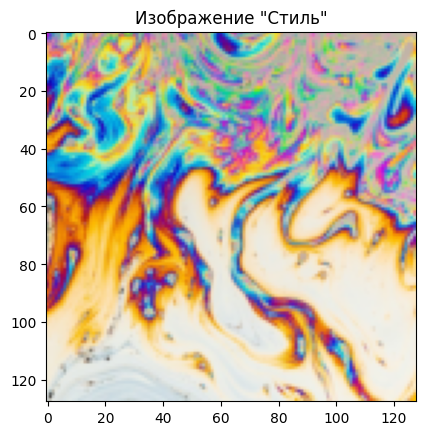

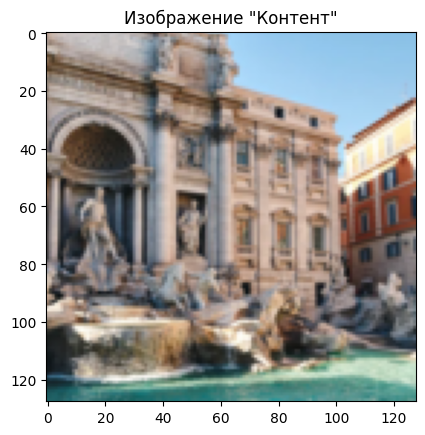

In [49]:
unloader = transforms.ToPILImage()  # Преобразуем в картинку PIL

plt.ion()

def imshow(tensor, title=None):
    image = tensor.cpu().clone()  # создаем копию тензора чтобы не менять исходный
    image = image.squeeze(0)      # устраняем лишнее измерение (которое делало батч из изображения)
    image = unloader(image)
    plt.imshow(image)

    if title is not None:
        plt.title(title)
    plt.pause(0.001) # Дадим графику обновиться

plt.figure()
imshow(style_img, title='Изображение "Стиль"')

plt.figure()
imshow(content_img, title='Изображение "Контент"')

In [50]:
class ContentLoss(nn.Module):

    def __init__(self, target,):
        super(ContentLoss, self).__init__()
        # нуно "отвязать" (detach) набор целевых признаков (target content)
        # от других объектов, которые находят его градиент. Это статический объект
        # Если этого не сделать, метод forward вернут нам ошибку
        self.target = target.detach()

    def forward(self, input):
        self.loss = F.mse_loss(input, self.target)
        return input

In [51]:
def gram_matrix(input):
    a, b, c, d = input.size()
    # a=размер батча(=1)
    # b=количество карт признаков, для которых мы считаем матрицу
    # (c,d)=размерность карты признаков f (N=c*d)

    features = input.view(a * b, c * d)  # изменим размерность матрицы F_XL, получим \hat F_XL

    G = torch.mm(features, features.t())  # рассчитать произведение матриц чтобы получить матрицу Грама

    # нормализуем значения матрицы Грама, разделив значения матрицы на количество элементов
    return G.div(a * b * c * d)

In [52]:
class StyleLoss(nn.Module):

    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        self.target = gram_matrix(target_feature).detach()

    def forward(self, input):
        G = gram_matrix(input)
        self.loss = F.mse_loss(G, self.target)
        return input

In [53]:
cnn = vgg16(weights=VGG16_Weights.DEFAULT).features.eval()

In [54]:
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406])
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225])

# упаковочный класс, чтобы картинку было легче передать в объект ``nn.Sequential``
class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        # преобразуем мат.ожидание и дисперсию при помощи .view так, чтобы
        # их можно было легко умножить на тензор с картинкой
        # Картинка имеет размерность [B x C x H x W]
        # Мы приводим коэффициенты нормализации к размерности [C x 1 x 1]
        # B – размер батча. C – количество каналов. H – высота, W – ширина изображения.
        self.mean = torch.tensor(mean).view(-1, 1, 1)
        self.std = torch.tensor(std).view(-1, 1, 1)

    def forward(self, img):
        # нормализуем изображение ``img``
        return (img - self.mean) / self.std

In [55]:
# названия слоев, где мы будем рассчитывать расхождение по контенту
content_layers_default = ['conv_4']
# названия слоев, где мы будем рассчитывать расхождение по стилю
style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

def get_style_model_and_losses(cnn, normalization_mean, normalization_std,
                               style_img, content_img,
                               content_layers=content_layers_default,
                               style_layers=style_layers_default):
    # модуль чтобы нормализоавть изображения
    normalization = Normalization(normalization_mean, normalization_std)

    # будем складывать меры расхождения (лоссы) в удобные массивы
    content_losses = []
    style_losses = []

    # поскольку ``cnn`` является объектом типа ``nn.Sequential``,
    # создадим новый ``nn.Sequential`` куда мы по порядку положим
    # все модули, которые будут проводить вычисления в нейросети
    model = nn.Sequential(normalization)

    i = 0  # пройдемся по элементам в исходной нейросети и дадим им имена
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'conv_{}'.format(i)
        elif isinstance(layer, nn.ReLU):
            name = 'relu_{}'.format(i)
            # Чуть изменим параметры слоев активации (версия которая использована
            # в исходной нейросети не работает с нашей реализацией ``ContentLoss`` и ``StyleLoss``)
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool_{}'.format(i)
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_{}'.format(i)
        else:
            raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

        # Добавим очередной модуль в нашу Sequential-модель
        model.add_module(name, layer)

        if name in content_layers:
            # если к последнему слою нужно пристыковать контент-лосс, сделаем это
            target = model(content_img).detach()
            content_loss = ContentLoss(target)
            model.add_module("content_loss_{}".format(i), content_loss)
            content_losses.append(content_loss)

        if name in style_layers:
            # а если имя слоя в списке стиль-лоссов, добавим после него соответствующий лосс
            target_feature = model(style_img).detach()
            style_loss = StyleLoss(target_feature)
            model.add_module("style_loss_{}".format(i), style_loss)
            style_losses.append(style_loss)

    # все слои которые идут после последнего добавленного контент-лосса или стиль-лосса
    # нам будут не нужны, их можно отбросить
    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break

    model = model[:(i + 1)]

    return model, style_losses, content_losses


In [57]:
def get_input_optimizer(input_img):
    optimizer = optim.LBFGS([input_img])
    return optimizer

In [48]:
def get_input_optimizer(input_img: torch.Tensor) -> optim.Optimizer:
    if not isinstance(input_img, torch.Tensor):
        raise TypeError("input_img должно быть экземпляром torch.Tensor")

    optimizer = optim.LBFGS([input_img])

    return optimizer

In [58]:
def run_style_transfer(cnn, normalization_mean, normalization_std,
                       content_img, style_img, input_img, num_steps=300,
                       style_weight=1000, content_weight=1):

    print('Построение модели переноса стиля..')
    model, style_losses, content_losses = get_style_model_and_losses(cnn,
        normalization_mean, normalization_std, style_img, content_img)

    # Укажем, какой объект мы будем оптимизировать (включить параметр requires_grad fields)
    input_img.requires_grad_(True)
    # Переключим модель в режим исполнения, чтобы заморозить слои вроде dropout или батч нормализации normalization layers
    model.eval()
    # Очевидно, мы не будем оптимизировать модель, так что заморозим все параметры
    model.requires_grad_(False)

    optimizer = get_input_optimizer(input_img)

    print('Оптимизируем картинку..')
    run = [0]
    while run[0] <= num_steps:

        def closure():
            # скорректируем значения входного изображения
            with torch.no_grad():
                input_img.clamp_(0, 1)

            optimizer.zero_grad() # обнуляем градиенты (иногда их используют между итерациями, но не сейчас)
            model(input_img) # знакомая вам функция, отправить картинку в модель

            # Посчитаем расхождение изображений по стилю и содержимому
            style_score = 0
            content_score = 0

            for sl in style_losses: style_score += sl.loss
            for cl in content_losses: content_score += cl.loss

            style_score *= style_weight # Домножаем каждую компоненту лосса на заданный вес
            content_score *= content_weight

            loss = style_score + content_score
            # И по этому значению осуществляем обратное распространение ошибки (обратно по сети, вплоть до изображения)
            loss.backward()

            run[0] += 1
            if run[0] % 50 == 0:
                print("run {}:".format(run))
                print('Style Loss : {:4f} Content Loss: {:4f}'.format(
                    style_score.item(), content_score.item()))
                print()

            return style_score + content_score

        optimizer.step(closure)

    # и в последний раз вернем изображение в диапазон
    with torch.no_grad():
        input_img.clamp_(0, 1)

    return input_img

Построение модели переноса стиля..


/usr/local/lib/python3.10/dist-packages/torch/utils/_device.py:79: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return func(*args, **kwargs)


Оптимизируем картинку..
run [50]:
Style Loss : 7.187062 Content Loss: 24.458664

run [100]:
Style Loss : 7.299041 Content Loss: 23.400547

run [150]:
Style Loss : 7.137758 Content Loss: 23.158865

run [200]:
Style Loss : 6.955934 Content Loss: 24.690487

run [250]:
Style Loss : 8.081053 Content Loss: 27.925014

run [300]:
Style Loss : 10.040164 Content Loss: 28.225628



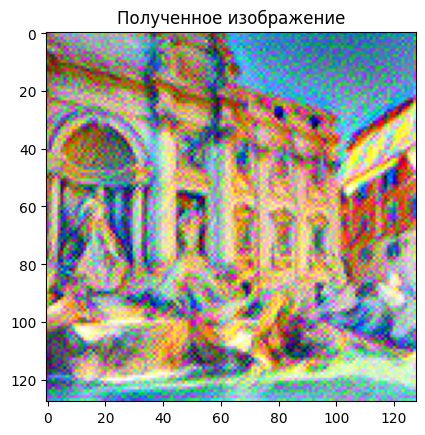

In [59]:
def display_output(output, title='Полученное изображение'):

    plt.figure()
    imshow(output, title=title)
    plt.ioff()  # Выключаем интерактивный режим
    plt.show()

# Запуск переноса стиля
try:
    output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                                content_img, style_img, input_img)

    # Отображаем полученное изображение
    display_output(output)

except Exception as e:
    print(f"Произошла ошибка во время переноса стиля: {e}")

Построение модели переноса стиля..
Оптимизируем картинку..
run [50]:
Style Loss : 5430.560547 Content Loss: 57.535507

run [100]:
Style Loss : 2543.882812 Content Loss: 65.436440

run [150]:
Style Loss : 1668.576172 Content Loss: 70.094345

run [200]:
Style Loss : 1163.845947 Content Loss: 73.382278

run [250]:
Style Loss : 890.409119 Content Loss: 75.909889

run [300]:
Style Loss : 753.806030 Content Loss: 78.250465



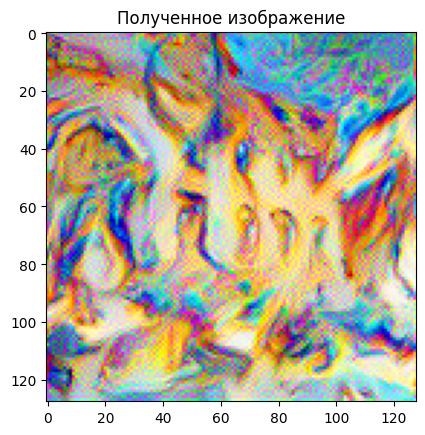

In [60]:
# Выполнение переноса стиля
num_steps = 300          # Количество шагов обучения
style_weight = 1e7      # Вес стиля
content_weight = 1      # Вес контента

# Запуск функции переноса стиля
output = run_style_transfer(
    cnn,
    cnn_normalization_mean,
    cnn_normalization_std,
    content_img,
    style_img,
    input_img,
    num_steps=num_steps,
    style_weight=style_weight,
    content_weight=content_weight
)

# Отображение полученного изображения
plt.figure()
imshow(output, title='Полученное изображение')

# Выставление номера миниатюры для документации
# sphinx_gallery_thumbnail_number = 4

# Завершение режима интерактивного отображения и показ изображения
plt.ioff()
plt.show()